# Constant Stochastic Gradient

```
Can we approximately sample from a Bayesian posterior distribution if we are only allowed to touch a small mini-batch of data-items for every sample we generate ?
```

Based on results from a recent paper, a simple implementation of constant stochastic gradient is presented as an approximate bayesian sampling algorithm. The objective of the notebook is to compare the approximate distribution to iterates from NUTS and SGFS.

Ref: https://arxiv.org/abs/1704.04289

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymc3 as pm

In [2]:
from collections import OrderedDict
import warnings
import theano
import numpy as np
rng = np.random.RandomState(0)

In [3]:
import pandas as pd
import theano.tensor as tt
import seaborn as sns

We will take a regression on a protein dataset that is used to show results in Figure 1. 
It is a multivariate regression problem on the Protein Structure Properties dataset available at the [uci repo](https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure).

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv --directory-prefix=/tmp/

--2017-11-26 17:48:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv
Resolving archive.ics.uci.edu... 128.195.10.249
Connecting to archive.ics.uci.edu|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3528710 (3.4M) [text/csv]
Saving to: ‘/tmp/CASP.csv.4’

CASP.csv.4          100%[===================>]   3.37M  1.41MB/s    in 2.4s    

2017-11-26 17:48:22 (1.41 MB/s) - ‘/tmp/CASP.csv.4’ saved [3528710/3528710]



### Load dataset

In [5]:
raw_data = pd.read_csv('/tmp/CASP.csv', delimiter=',')
data = (raw_data - raw_data.mean())/raw_data.std()
q_size = data.shape[1]-1
q_name = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']

In [6]:
data_N = data.size/len(data.columns)
train_test_split = 0.95
ixs = rng.randint(data_N, size=int(data_N*train_test_split))
neg_ixs = list(set(range(data_N)) - set(ixs))
train_df = data.iloc[ixs]
test_df = data.iloc[neg_ixs]

N = train_df.size / len(train_df.columns)
n_test = test_df.size / len(test_df.columns)

In [7]:
train_X = train_df[q_name].as_matrix()
train_Y = train_df['RMSD'].as_matrix()

test_X = test_df[q_name].as_matrix()
test_Y = test_df['RMSD'].as_matrix()

Let's try regression models from sklearn to construct the best pymc3 model

In [8]:
from sklearn import linear_model
sklearn_regression_model = {
    'Ridge': linear_model.Ridge (alpha = .5),
    'Lasso': linear_model.Lasso(alpha = 0.1),
    'BayesianRidge': linear_model.BayesianRidge(),
    'OLS': linear_model.LinearRegression(),
}
for name, reg in sklearn_regression_model.items():
    reg.fit(train_X, train_Y) 
    pred = reg.predict(test_X)
    diff = pred-test_Y
    print('The {} Mean Absolute Error is {}'.format(name, np.sum(np.abs(diff))/test_Y.size))

The BayesianRidge Mean Absolute Error is 0.705775225403
The OLS Mean Absolute Error is 0.705739946132
The Ridge Mean Absolute Error is 0.705748180444
The Lasso Mean Absolute Error is 0.798798476908


/Users/shashank/.virtualenvs/pymc3-dev/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


OLS fit has the minimum mean absolute error so we will select normal priors on the model parameters

In [9]:
model_input = theano.shared(train_X, name='X')
model_output = theano.shared(train_Y, name='Y')

with pm.Model() as model:
    b0 = pm.Normal("Intercept", mu=0.0, sd=1.0)
    b1 = pm.Normal("Slope", mu=0.0, shape=(q_size,))
    std = pm.HalfNormal("std", sd=1.0)

    mu = b0 + theano.dot(model_input, b1)      
    y_obs = pm.Normal("y_obs", mu=mu, sd=std, observed=model_output) 

In [10]:
with model:
    start = pm.find_MAP()
    
map_pred = np.matmul(test_X, start['Slope'] ) + start['Intercept']
map_diff = map_pred-test_Y
print('The {} Mean Absolute Error is {}'.format("OLS MAP Estimate", np.sum(np.abs(map_diff))/test_Y.size))

         Current function value: 54415.487519
         Iterations: 20
         Function evaluations: 70
         Gradient evaluations: 61
The OLS MAP Estimate Mean Absolute Error is 0.70575174425


Now we will to proceed perform bayesian sampling to calculate the posterior on the OLS pymc3 model.

Make model and minibatches input for the stochastic sampler

In [11]:
draws = 10000
with model:
    nuts_trace = pm.sample(draws=draws, tune=500)     

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10500/10500 [11:20<00:00, 15.44it/s]


In [12]:
# Generator that returns mini-batches in each iteration
def create_minibatches(batch_size):
    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(N, size=batch_size)
        yield (train_X[ixs], train_Y[ixs])

# Tensors and RV that wil l be using mini-batches
batch_size = 50
minibatches = create_minibatches(batch_size)

In [13]:
model_input = theano.shared(train_X, name='X')
model_output = theano.shared(train_Y, name='Y')

with pm.Model() as model:
    b0 = pm.Normal("Intercept", mu=0.0, sd=1.0)
    b1 = pm.Normal("Slope", mu=0.0, shape=(q_size,))
    std = pm.HalfNormal("std", sd=1.0)

    mu = b0 + theano.dot(model_input, b1)      
    y_obs = pm.Normal("y_obs", mu=mu, sd=std, observed=model_output) 
    
minibatch_tensors = [model_input, model_output]

draws = 10000*5
with model:
    csg_step_method = pm.step_methods.CSG(vars=model.vars,
                                          model=model,
                                          total_size=N, 
                                          batch_size=batch_size,
                                          minibatches=minibatches, 
                                          minibatch_tensors=minibatch_tensors) 
    csg_trace = pm.sample(draws=draws, step=csg_step_method, tune=500, init='map')     

/Users/shashank/.virtualenvs/pymc3-dev/lib/python2.7/site-packages/pymc3-3.1-py2.7.egg/pymc3/step_methods/sgmcmc.py:112: UserWarning: Warning: Stochastic Gradient based sampling methods are experimental step methods and not yet recommended for use in PyMC3!
100%|██████████| 50500/50500 [01:17<00:00, 651.88it/s]


In [14]:
model_input = theano.shared(train_X, name='X')
model_output = theano.shared(train_Y, name='Y')

with pm.Model() as model:
    b0 = pm.Normal("Intercept", mu=0.0, sd=1.0)
    b1 = pm.Normal("Slope", mu=0.0, shape=(q_size,))
    std = pm.HalfNormal("std", sd=1.0)

    mu = b0 + theano.dot(model_input, b1)      
    y_obs = pm.Normal("y_obs", mu=mu, sd=std, observed=model_output) 
    
minibatch_tensors = [model_input, model_output]

draws = 10000*5
with model:
    sgfs_step_method = pm.step_methods.SGFS(vars=model.vars,
                                            step_size=0.1,
                                            step_size_decay=1000,
                                            total_size=N,
                                            batch_size=batch_size,
                                            minibatches=minibatches, 
                                            minibatch_tensors=minibatch_tensors)  
    sgfs_trace = pm.sample(draws=draws, step=sgfs_step_method, tune=500, init='map')     

100%|██████████| 50500/50500 [01:17<00:00, 650.24it/s]


### NUTS Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120ed9fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12775f110>]], dtype=object)

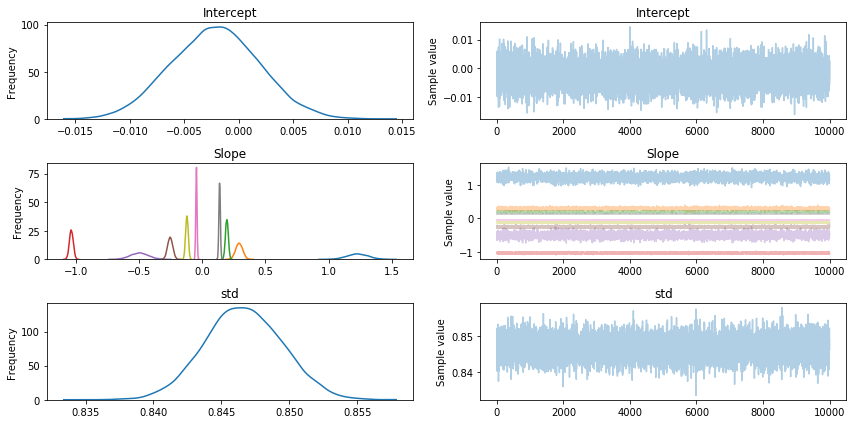

In [15]:
pm.traceplot(nuts_trace)

### Preconditioned CSG Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127cf7d90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f7ff2d0>]], dtype=object)

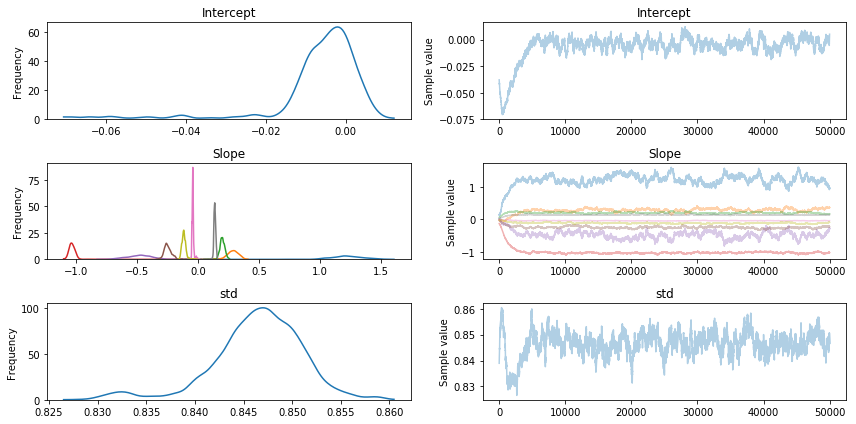

In [16]:
pm.traceplot(csg_trace)

### SGFS Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1210e01d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11cb443d0>]], dtype=object)

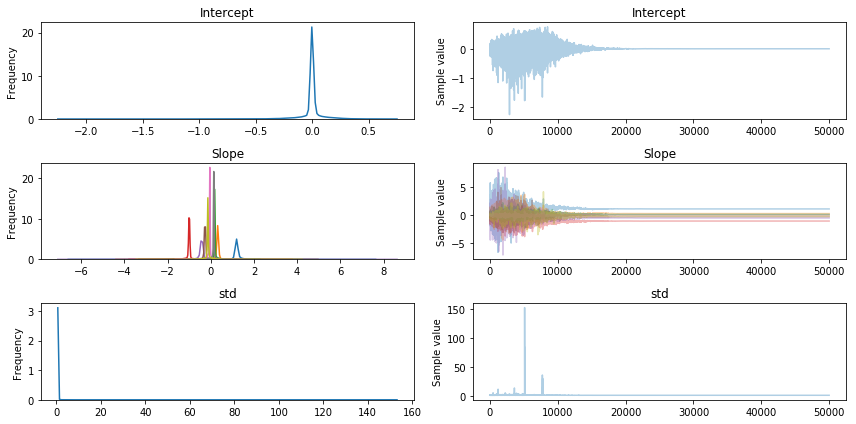

In [17]:
pm.traceplot(sgfs_trace)

### Mean Absolute Error on Test Dataset

In [18]:
# Replace shared variables with testing set
model_input.set_value(test_X)
model_output.set_value(test_Y)

samples = 1000

# Creater posterior predictive samples
sgfs_ppc = pm.sample_posterior_predictive(sgfs_trace, model=model, samples=samples, random_seed=0)
sgfs_pred = sgfs_ppc['y_obs'].mean(axis=0)

# Creater posterior predictive samples
csg_ppc = pm.sample_posterior_predictive(csg_trace, model=model, samples=samples, random_seed=0)
csg_pred = csg_ppc['y_obs'].mean(axis=0)

# Nuts predictive samples
nuts_ppc = pm.sample_posterior_predictive(nuts_trace, model=model, samples=samples, random_seed=0)
nuts_pred = nuts_ppc['y_obs'].mean(axis=0)

sgfs_diff = sgfs_pred-test_Y
csg_diff = csg_pred-test_Y
nuts_diff = nuts_pred-test_Y

100%|██████████| 1000/1000 [00:01<00:00, 723.95it/s]


In [19]:
print('The NUTS Mean Absolute Error is {}'.format(np.sum(np.abs(nuts_diff))/test_Y.size))
print('The CSG Mean Absolute Error is {}'.format(np.sum(np.abs(csg_diff))/test_Y.size))
print('The SGFS Mean Absolute Error is {}'.format(np.sum(np.abs(sgfs_diff))/test_Y.size))

The NUTS Mean Absolute Error is 0.705957002724
The CSG Mean Absolute Error is 0.706815746717
The SGFS Mean Absolute Error is 0.704868369491


The mean absolute error for all the sampling algorithms is ~ 0.706. which is very close to the ols map fit
0.7057. The error is slightly better using SGFS.

/Users/shashank/.virtualenvs/pymc3-dev/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


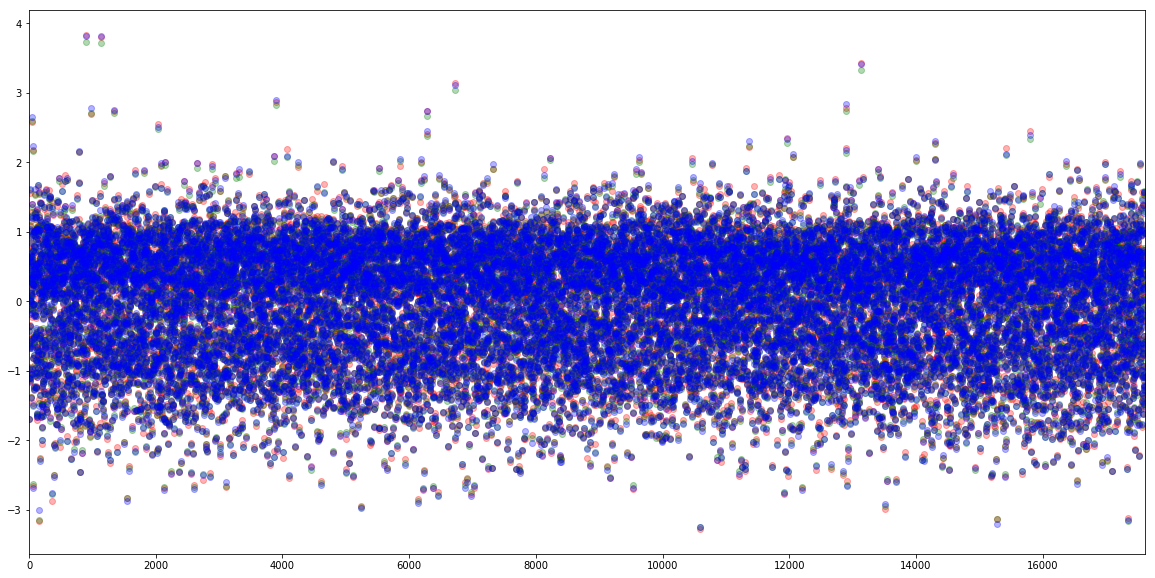

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.tsplot(data=nuts_diff, ax=ax, color="r", interpolate=False, alpha=0.3)
sns.tsplot(data=csg_diff, ax=ax, color="g", interpolate=False, alpha=0.3)
sns.tsplot(data=sgfs_diff, ax=ax, color="b", interpolate=False, alpha=0.3)

### Sample covariance projections on the smallest and largest components

In [21]:
def posterior_covariance(step_method, trace):
    bij = pm.DictToArrayBijection(step_method.ordering, step_method.model.test_point)
    q_size = bij.map(step_method.model.model.test_point).size
    sample_size = len(trace)
    posterior = np.empty((q_size, sample_size))
    for index, point in enumerate(trace):
        posterior[:, index] = bij.map(point)
    posterior_minus_mean = posterior - np.asmatrix(posterior.mean(axis=1)).T
    normalized_posterior = posterior_minus_mean / np.asmatrix(posterior.std(axis=1)).T
    cov = np.matmul(normalized_posterior, normalized_posterior.T)
    return posterior_minus_mean, cov

def projection(posterior, cov):
    U, S, V_h = np.linalg.svd(a=cov, compute_uv=True, full_matrices=True)
    first_projection = V_h[0, :]
    last_projection = V_h[-1, :]
    q_size, samples = posterior.shape
    projection_matrix = np.empty((samples, 2))
    for i in range(samples):
        projection_matrix[i, 0] = np.matmul(first_projection, posterior_minus_mean[:, i])
        projection_matrix[i, 1] = np.matmul(last_projection, posterior_minus_mean[:, i])
    return projection_matrix

burn_in = 500

### Between CSG and NUTS

Text(0.5,1,u'Stationary sampling distributions of the iterates of CSG and NUTS')

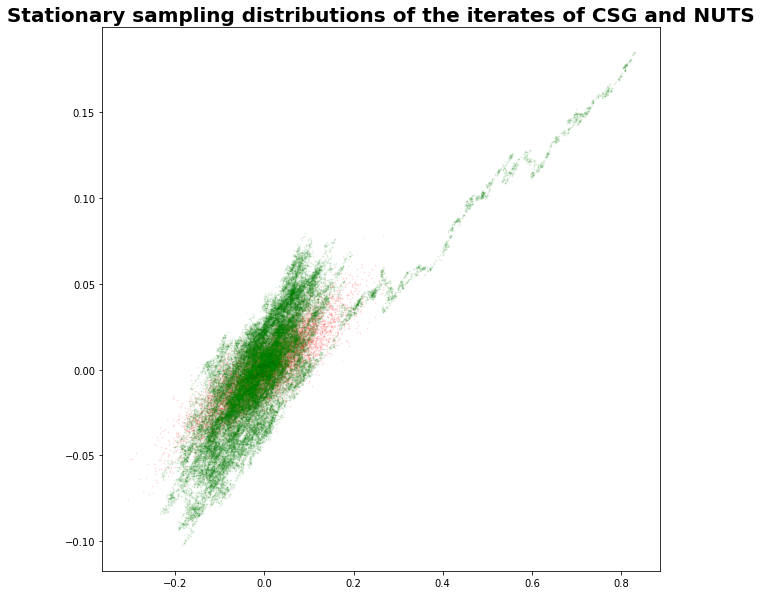

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

posterior_minus_mean, cov = posterior_covariance(csg_step_method, nuts_trace[burn_in:])
projection_matrix = projection(posterior_minus_mean, cov)
df_nuts = pd.DataFrame(projection_matrix, columns=['X', 'Y'])
ax.scatter(x=df_nuts['X'], y=df_nuts['Y'], s=0.5, alpha=0.1, c='r')

posterior_minus_mean, cov = posterior_covariance(csg_step_method, csg_trace[burn_in:])
projection_matrix = projection(posterior_minus_mean, cov)
df_csg = pd.DataFrame(projection_matrix, columns=['X', 'Y'])
ax.scatter(x=df_csg['X'], y=df_csg['Y'], s=0.5, alpha=0.1, c='g')


ax.set_title("Stationary sampling distributions of the iterates of CSG and NUTS", fontsize=20, fontweight='bold')

### Between SGFS and NUTS

Text(0.5,1,u'stationary sampling distributions of the iterates of SGFS and NUTS')

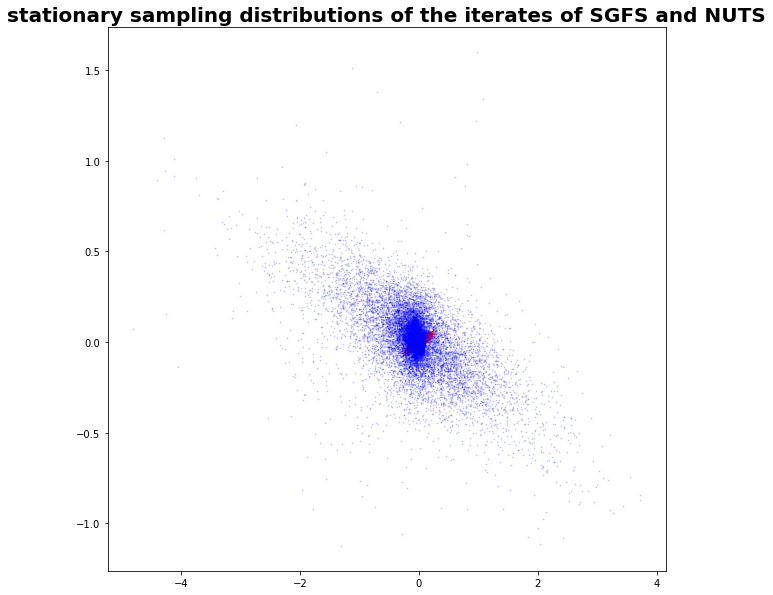

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

posterior_minus_mean, cov = posterior_covariance(csg_step_method, nuts_trace[burn_in:])
projection_matrix = projection(posterior_minus_mean, cov)
df_nuts = pd.DataFrame(projection_matrix, columns=['X', 'Y'])
ax.scatter(x=df_nuts['X'], y=df_nuts['Y'], s=0.5, alpha=0.2, c='r')

posterior_minus_mean, cov = posterior_covariance(sgfs_step_method, sgfs_trace[burn_in:])
projection_matrix = projection(posterior_minus_mean, cov)
df_sgfs = pd.DataFrame(projection_matrix, columns=['X', 'Y'])
ax.scatter(x=df_sgfs['X'], y=df_sgfs['Y'], s=0.5, alpha=0.2, c='b')

ax.set_title("stationary sampling distributions of the iterates of SGFS and NUTS", fontsize=20, fontweight='bold')

### Result

Constant Stochastic Gradient is a good approximator of the posterior, as can be seen from the trace plots and the projections of its sample covariance matrix which 
largely overlap with NUTS. The paper also presents a figure which shows large overlap between the true posterior and the constant stochastic gradient iteratre distribution. In comparison SGFS has a unique distribution, which shows a different relationship between the two components.